<a href="https://colab.research.google.com/github/hamednasr/transformers/blob/main/fine_tuning_machine_translation_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install transformers datasets sentencepiece bert-score

In [2]:
from datasets import load_dataset, load_metric
from transformers import (AutoTokenizer,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer,
                          AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq,
                          pipeline,
                          AutoConfig)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = load_dataset('kde4',lang1 = 'en', lang2 ='fr')
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [4]:
data['train']['translation'][11]

{'en': 'The Babel & konqueror; plugin',
 'fr': 'Le module externe Babel pour & konqueror;'}

In [40]:
subdata = data['train'].shuffle(seed=2).select(range(5000))

In [41]:
split = subdata.train_test_split(test_size=0.1, seed=4)

In [42]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 500
    })
})

In [43]:
split['train']['translation'][22]

{'en': 'Cannot open file for writing.',
 'fr': "Impossible d'écrire dans le fichier."}

In [44]:
split['train']['translation'][3]['en']

'Show drop target'

In [45]:
split['train']['translation'][3]['fr']

'Afficher la cible de dépôt'

In [46]:
checkpoint='Helsinki-NLP/opus-mt-en-fr'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [47]:
inputs = tokenizer(split['train']['translation'][3]['en'])
inputs

{'input_ids': [5118, 8428, 3988, 0], 'attention_mask': [1, 1, 1, 1]}

In [48]:
targets = tokenizer(text_target = split['train']['translation'][3]['fr'])
targets

{'input_ids': [8140, 8, 8178, 5, 5323, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [49]:
#check if it is correct
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Afficher', '▁la', '▁cible', '▁de', '▁dépôt', '</s>']

In [50]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['▁Show', '▁drop', '▁target', '</s>']

In [51]:
len(' i love you'.split())

3

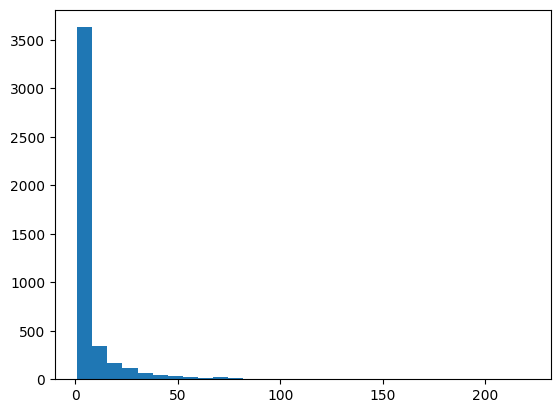

In [52]:
# specify the length of input tokens
plt.hist([len(x['en'].split()) for x in split['train']['translation']], bins=30);

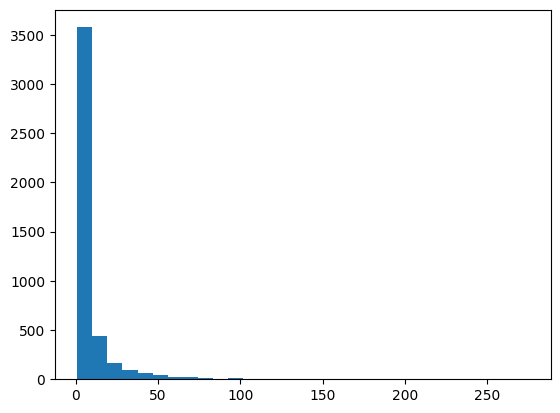

In [53]:
# specify the length of output tokens
plt.hist([len(x['fr'].split()) for x in split['train']['translation']], bins=30);

In [54]:
max_input_length = 40
max_target_length = 40

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  tokenized_inputs = tokenizer(inputs, max_length= max_input_length, truncation = True)
  tokenized_targets = tokenizer(text_target = targets, max_length= max_target_length, truncation = True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']

  return tokenized_inputs

In [55]:
tokenized_datasets = split.map(tokenizer_fn, batched=True, remove_columns=split['train'].column_names)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [56]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [57]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [58]:
#test data collator
[tokenized_datasets['train'][i] for i in range(1,3)]

[{'input_ids': [35, 6564, 7378, 0],
  'attention_mask': [1, 1, 1, 1],
  'labels': [60, 2805, 7768, 0]},
 {'input_ids': [5489, 0], 'attention_mask': [1, 1], 'labels': [14775, 0]}]

In [59]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [60]:
batch['labels']

tensor([[   60,  2805,  7768,     0],
        [14775,     0,  -100,  -100]])

In [61]:
batch['decoder_input_ids']

tensor([[59513,    60,  2805,  7768],
        [59513, 14775,     0, 59513]])

In [62]:
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0])

['<pad>', '▁Le', '▁menu', '▁Aide']

In [63]:
tokenizer.convert_ids_to_tokens(batch['labels'][0])

['▁Le', '▁menu', '▁Aide', '</s>']

In [64]:
bert_metric = load_metric('bertscore')

In [65]:
bert_metric.compute(predictions=['I am unable to see the results of the work'],
                    references=[['I cannot see the outputs of the job']],
                    lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9446243047714233],
 'recall': [0.9483727216720581],
 'f1': [0.9464947581291199],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.34.0)'}

In [66]:
def compute_metrics(preds_labels):
  preds, labels = preds_labels
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels!=-100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bert_score = bert_metric.compute(predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {'bert-score': np.mean(bert_score['f1'])}

In [ ]:
pip install accelerate -U

In [68]:
training_args = Seq2SeqTrainingArguments('finetuned-model',
                                         evaluation_strategy='no',
                                         save_strategy = 'epoch',
                                         learning_rate = 2e-5,
                                         per_device_train_batch_size=16,
                                         per_device_eval_batch_size=16,
                                         weight_decay=0.01,
                                         save_total_limit=3,
                                         predict_with_generate=True,
                                         fp16=True  )

In [69]:
trainer = Seq2SeqTrainer(model,
                        training_args,
                        train_dataset = tokenized_datasets['train'],
                        eval_dataset = tokenized_datasets['test'],
                        data_collator = data_collator,
                        compute_metrics = compute_metrics,
                        tokenizer = tokenizer
                         )

In [70]:
trainer.evaluate(max_length=max_target_length)

{'eval_loss': 2.0114006996154785,
 'eval_bert-score': 0.8577855596542359,
 'eval_runtime': 72.0576,
 'eval_samples_per_second': 6.939,
 'eval_steps_per_second': 0.444}

In [71]:
trainer.train()

Step,Training Loss
500,1.434300


TrainOutput(global_step=846, training_loss=1.3215892602365913, metrics={'train_runtime': 135.4078, 'train_samples_per_second': 99.699, 'train_steps_per_second': 6.248, 'total_flos': 122087079936000.0, 'train_loss': 1.3215892602365913, 'epoch': 3.0})

In [72]:
trainer.evaluate(max_length=max_target_length)

{'eval_loss': 1.454614520072937,
 'eval_bert-score': 0.8741401196718216,
 'eval_runtime': 31.2374,
 'eval_samples_per_second': 16.006,
 'eval_steps_per_second': 1.024,
 'epoch': 3.0}

In [73]:
trainer.save_model('translation_model')

In [75]:
translator = pipeline('translation', model='translation_model', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [76]:
translator('I am a student and I need your help in my project!')

[{'translation_text': "Je suis étudiant et j'ai besoin de votre aide dans mon projet!"}]